---
title: "Pyspark Business Report 2"
subtitle: "A practice example of a pyspark business report using the JOIN method"
author: "Dennis Feyerabend"
date: today                    # or "2025-01-15" or last-modified
date-format: long              # short, medium, long, full, or custom
abstract: "The project demonstrates a full customer-segmentation workflow in PySpark, combining advanced statistical aggregation with relational joins to assemble a consolidated master dataset for downstream business reporting."

# Table of Contents
toc: true                        # Enable table of contents
toc-depth: 4                     # How many heading levels to include (1-6)
toc-title: "Contents"            # Custom TOC title
number-sections: true            # Add numbers to headings
number-depth: 4                  # How deep to number

# Code Display (Global Defaults)
execute:
  echo: true                     # Show code in output
  eval: true                     # Run the code
  warning: false                 # Hide warnings
  error: false                   # Stop on errors (true = continue)
  output: true                   # Show output


format:
  html:
    theme: ../themes/quarto_arrakis-night.scss
    embed-resources: true # Embed resources in HTML
    toc: true
    toc-location: right
    code-fold: true # Hide code blocks by default
---

In [21]:
#| echo: false
#| output: false

import sys
import os
from tkinter.tix import Select

from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, sum, count, when, filter,
    round as spark_round, avg, desc,
    max as spark_max, min as spark_min,
    lit, datediff,
    year, month, dayofweek
)
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Apply> Arrakis Night to all plots
from themes import plot_arrakis_night_style
plot_arrakis_night_style.apply()

python_exec = sys.executable

os.environ["PYSPARK_PYTHON"] = python_exec
os.environ["PYSPARK_DRIVER_PYTHON"] = python_exec

spark = SparkSession.builder \
    .appName("Pyspark Join Project") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.pyspark.python", python_exec) \
    .config("spark.pyspark.driver.python", python_exec) \
    .getOrCreate()
spark.sparkContext.setLogLevel("WARN")

DATA_PATH = "../data/ecommerce_5m.csv"

df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

print("=" * 60)
print("   KUNDEN-ANALYSE DASHBOARD")
print("=" * 60)

print(f"\nDaten geladen: {df.count():,} Bestellungen")
print(f"Spalten: {df.columns}")

✓ Arrakis Night 'Rivers in the Desert' theme applied
  → Title: Peach | Labels: Gold | Ticks: Gray | Data: Water blues/greens
   KUNDEN-ANALYSE DASHBOARD

Daten geladen: 5,000,000 Bestellungen
Spalten: ['transaction_id', 'customer_id', 'date', 'product_category', 'product_price', 'quantity', 'payment_method', 'country', 'customer_age', 'total']


# Generate customer tables

## Tabelle 1: Kunden-Umsatz

In [2]:
#| echo: true
#| output: false

# ============================================================
# TABELLE 1: Kunden-Umsatz (Customer Value)
# ============================================================

print("\n" + "=" * 60)
print("TABELLE 1: Kunden-Umsatz")
print("=" * 60)

kunden_umsatz = df.groupBy("customer_id").agg(
    count("*").alias("anzahl_bestellungen"),
    spark_round(sum("total"), 2).alias("gesamt_umsatz"),
    spark_round(avg("total"), 2).alias("durchschnitt_bestellung")
)

print(f"\nAnzahl Kunden: {kunden_umsatz.count():,}")
print("\nTop 10 nach Umsatz:")
kunden_umsatz.orderBy(desc("gesamt_umsatz")).show(10)


TABELLE 1: Kunden-Umsatz

Anzahl Kunden: 489,975

Top 10 nach Umsatz:
+-----------+-------------------+-------------+-----------------------+
|customer_id|anzahl_bestellungen|gesamt_umsatz|durchschnitt_bestellung|
+-----------+-------------------+-------------+-----------------------+
|      85733|                 17|     25860.02|                1521.18|
|     467514|                 18|     25849.61|                1436.09|
|     455882|                 17|     25711.89|                1512.46|
|      53226|                 20|      25558.9|                1277.95|
|     484406|                 19|      25450.5|                 1339.5|
|      52421|                 18|     24621.72|                1367.87|
|     331378|                 16|     24455.04|                1528.44|
|     142060|                 18|     24410.15|                1356.12|
|      26705|                 18|     24174.79|                1343.04|
|      75067|                 15|     24134.88|                16

## Tabelle 2: Kunden-Aktivität

In [3]:
#| echo: true
#| output: false

# ============================================================
# TABELLE 2: Kunden-Aktivitaet (Letzte Bestellung)
# ============================================================

print("\n" + "=" * 60)
print("TABELLE 2: Kunden-Aktivität")
print("=" * 60)

kunden_aktivitaet = df.groupBy("customer_id").agg(
    spark_max("date").alias("letzte_bestellung"),
    spark_min("date").alias("erste_bestellung")
)

print("\nBeispiel Aktivität:")
kunden_aktivitaet.show(10)


TABELLE 2: Kunden-Aktivität

Beispiel Aktivität:
+-----------+-----------------+----------------+
|customer_id|letzte_bestellung|erste_bestellung|
+-----------+-----------------+----------------+
|     482803|       2024-11-16|      2023-02-06|
|     105665|       2024-10-18|      2023-02-01|
|      97218|       2024-10-05|      2023-02-10|
|     478897|       2024-12-24|      2023-03-21|
|     192082|       2024-12-27|      2023-01-25|
|     158593|       2024-12-03|      2023-05-23|
|     307303|       2024-09-07|      2023-01-09|
|     460693|       2024-09-19|      2023-01-05|
|     102594|       2024-10-17|      2023-01-21|
|     375701|       2024-11-26|      2023-01-20|
+-----------+-----------------+----------------+
only showing top 10 rows


## Tabelle 3: Kunden-Demografie

In [4]:
#| echo: true
#| output: false

# ============================================================
# TABELLE 3: Kunden-Demografie (Land, Alter)
# ============================================================

print("\n" + "=" * 60)
print("TABELLE 3: Kunden-Demografie")
print("=" * 60)

# Wir nehmen die haeufigsten Werte pro Kunde
# Modus (haeufigster Wert) simulieren mit first()
kunden_demografie = df.groupBy("customer_id").agg(
    spark_round(avg("customer_age"), 0).alias("alter"),
    count(when(col("country") == "Germany", 1)).alias("bestellungen_de"),
    count(when(col("country") == "Austria", 1)).alias("bestellungen_at"),
    count(when(col("country") == "Switzerland", 1)).alias("bestellungen_ch")
)

# DACH-Kunde ja/nein
kunden_demografie = kunden_demografie.withColumn(
    "ist_dach_kunde",
    when(
        (col("bestellungen_de") > 0) |
        (col("bestellungen_at") > 0) |
        (col("bestellungen_ch") > 0),
        "Ja"
    ).otherwise("Nein")
)

print("\nBeispiel Demografie:")
kunden_demografie.show(10)



TABELLE 3: Kunden-Demografie

Beispiel Demografie:
+-----------+-----+---------------+---------------+---------------+--------------+
|customer_id|alter|bestellungen_de|bestellungen_at|bestellungen_ch|ist_dach_kunde|
+-----------+-----+---------------+---------------+---------------+--------------+
|     482803| 50.0|              4|              2|              2|            Ja|
|     105665| 47.0|              3|              4|              0|            Ja|
|      97218| 52.0|              2|              2|              2|            Ja|
|     478897| 49.0|              4|              0|              0|            Ja|
|     192082| 47.0|              6|              2|              2|            Ja|
|     158593| 40.0|              6|              1|              1|            Ja|
|     307303| 43.0|              6|              3|              2|            Ja|
|     460693| 38.0|              3|              2|              3|            Ja|
|     102594| 53.0|              5|

# Join functions

In [5]:
#| echo: true
#| output: false

# ============================================================
# MASTER-TABELLE: Alle Daten zusammen
# ============================================================

print("\n" + "=" * 60)
print("MASTER JOIN: Alle Tabellen verbinden")
print("=" * 60)

anz_kunden = df.select("customer_id").distinct().count()
print(f'Bevor JOIN: {anz_kunden:,} Kunden')

# Erster JOIN: Umsatz + Aktivitaet
master_step1 = kunden_umsatz.join(
    kunden_aktivitaet, on="customer_id", how="inner"
)

print(f"Nach JOIN 1: {master_step1.count():,} Kunden")

# Zweiter JOIN: + Demografie
kunden_master = master_step1.join(
    kunden_demografie,
    "customer_id",
    "inner"
)

print(f"Nach JOIN 2: {kunden_master.count():,} Kunden")

# Letztes Datum fuer Inaktivitaet berechnen
max_date = df.agg(spark_max("date")).collect()[0][0]
# Berechne inaktivität vom max_date (heute)
kunden_master = kunden_master.withColumn("tage_inaktiv", datediff(lit(max_date), col("letzte_bestellung")))

print("\nMaster-Tabelle Beispiel:")
kunden_master.show(5)

print("\nSpalten in Master-Tabelle:")
for spalte in kunden_master.columns:
    print(f"  - {spalte}")


MASTER JOIN: Alle Tabellen verbinden
Bevor JOIN: 489,975 Kunden
Nach JOIN 1: 489,975 Kunden
Nach JOIN 2: 489,975 Kunden

Master-Tabelle Beispiel:
+-----------+-------------------+-------------+-----------------------+-----------------+----------------+-----+---------------+---------------+---------------+--------------+------------+
|customer_id|anzahl_bestellungen|gesamt_umsatz|durchschnitt_bestellung|letzte_bestellung|erste_bestellung|alter|bestellungen_de|bestellungen_at|bestellungen_ch|ist_dach_kunde|tage_inaktiv|
+-----------+-------------------+-------------+-----------------------+-----------------+----------------+-----+---------------+---------------+---------------+--------------+------------+
|      10013|                  8|      5778.63|                 722.33|       2024-10-12|      2023-04-16| 42.0|              4|              2|              0|            Ja|          79|
|      10022|                 11|      3794.03|                 344.91|       2024-12-20|      20

## Kunden-Segmente erstellen

In [6]:
#| echo: true
#| output: false

# ============================================================
# KUNDEN-SEGMENTIERUNG
# ============================================================

print("\n" + "=" * 60)
print("KUNDEN-SEGMENTIERUNG")
print("=" * 60)


# Segmente hinzufuegen
kunden_segmentiert = kunden_master \
    .withColumn("inaktiv", datediff(lit(max_date), col("letzte_bestellung"))
    ) \
    .withColumn("umsatz_segment",
        when(col("gesamt_umsatz") >= 5000, "VIP")
        .when(col("gesamt_umsatz") >= 1000, "Premium")
        .when(col("gesamt_umsatz") >= 200, "Standard")
        .otherwise("Gering")
    ) \
    .withColumn("aktivitaet_segment",
        when(col("tage_inaktiv") <= 30, "Aktiv")
        .when(col("tage_inaktiv") <= 90, "Inaktiv")
        .otherwise("Verloren")
    ) \
    .withColumn("alter_segment",
        when(col("alter") <= 25, "Jung")
        .when(col("alter") <= 40, "Mittel")
        .when(col("alter") <= 55, "Erfahren")
        .otherwise("Senior")
    )

print("\nSegmentierte Kunden:")
kunden_segmentiert.select(
    "customer_id",
    "gesamt_umsatz",
    "umsatz_segment",
    "tage_inaktiv",
    "aktivitaet_segment",
    "alter_segment",
    "ist_dach_kunde"
).show(15)


KUNDEN-SEGMENTIERUNG

Segmentierte Kunden:
+-----------+-------------+--------------+------------+------------------+-------------+--------------+
|customer_id|gesamt_umsatz|umsatz_segment|tage_inaktiv|aktivitaet_segment|alter_segment|ist_dach_kunde|
+-----------+-------------+--------------+------------+------------------+-------------+--------------+
|      10013|      5778.63|           VIP|          79|           Inaktiv|     Erfahren|            Ja|
|      10022|      3794.03|       Premium|          10|             Aktiv|     Erfahren|            Ja|
|      10032|      2807.79|       Premium|         167|          Verloren|       Mittel|            Ja|
|      10081|      6958.44|           VIP|         164|          Verloren|     Erfahren|            Ja|
|      10090|      1208.29|       Premium|         102|          Verloren|     Erfahren|            Ja|
|      10121|      1479.49|       Premium|         236|          Verloren|       Senior|            Ja|
|      10128|      5

# Business Reports

## REPORT 1: Umsatz nach Segment

In [35]:
#| echo: true
#| output: true

report_umsatz = kunden_segmentiert.groupBy("umsatz_segment").agg(
    count("*").alias("anzahl_kunden"),
    spark_round(sum("gesamt_umsatz")/1000000, 2).alias("segment_umsatz_mio"),
    spark_round(avg("gesamt_umsatz"), 2).alias("avg_umsatz")
).orderBy(desc("segment_umsatz_mio"))

# Generate Umsatz prozent column
window_all = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Percent of customers
report_umsatz = report_umsatz.withColumn(
    "kunden_prozent",
    spark_round(col("anzahl_kunden") / sum("anzahl_kunden").over(window_all)*100, 2))

report_umsatz = report_umsatz.withColumn(
    "segment_umsatz_prozent",
    spark_round(col("segment_umsatz_mio") / sum("segment_umsatz_mio").over(window_all)*100, 2))

# Reorder Spark columns BEFORE toPandas()
report_umsatz_reordered = report_umsatz.select(
    "umsatz_segment",
    "anzahl_kunden",
    "kunden_prozent",
    "segment_umsatz_mio",
    "avg_umsatz",
    "segment_umsatz_prozent"
)

# Convert to table
table_df = (
    report_umsatz_reordered.toPandas()
        .style.hide(axis="index")
        .format({
            "segment_umsatz_mio": "{:,.2f}",
            "avg_umsatz": "{:,.2f}",
            "segment_umsatz_prozent": "{:,.2f}",
            "kunden_prozent": "{:,.2f}",
        })
        .set_properties(
            subset=["anzahl_kunden", "kunden_prozent", "segment_umsatz_mio", "avg_umsatz", "segment_umsatz_prozent"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

table_df

umsatz_segment,anzahl_kunden,kunden_prozent,segment_umsatz_mio,avg_umsatz,segment_umsatz_prozent
VIP,272201,55.55,"2,141.35","7,866.80",74.89
Premium,211943,43.26,713.82,"3,367.99",24.97
Standard,5633,1.15,4.06,720.32,0.14
Gering,198,0.04,0.02,121.64,0.00


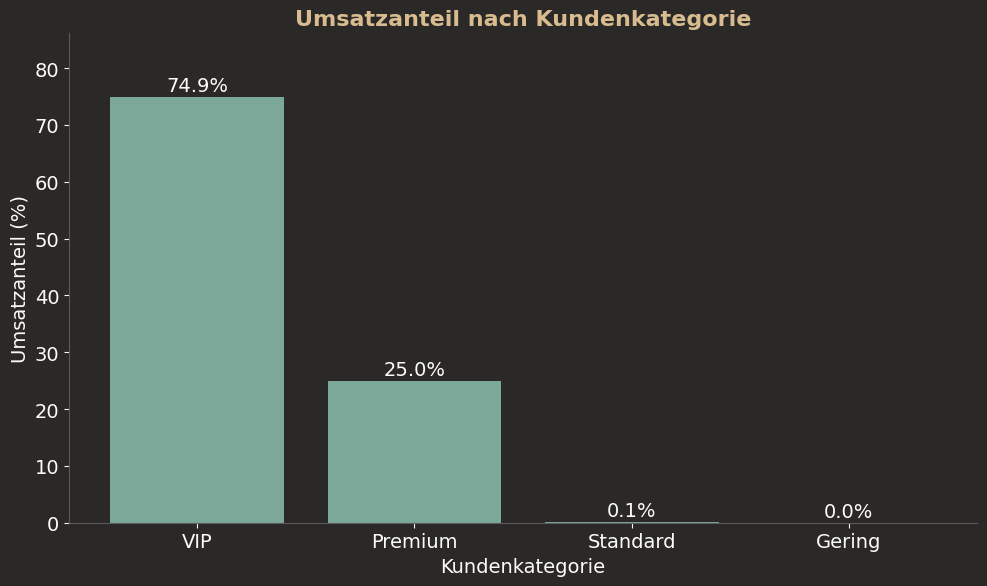

In [36]:
#| echo: false
#| output: true

# 2) Collect small result to Pandas for plotting
pdf = report_umsatz.select(
    "umsatz_segment", "segment_umsatz_prozent"
).toPandas()


fig, ax = plt.subplots(figsize=(10, 6))

# Barplot with automatically assigned colors
ax.bar(
    pdf["umsatz_segment"],
    pdf["segment_umsatz_prozent"]
)

# Labels & formatting
ax.set_title("Umsatzanteil nach Kundenkategorie", fontsize=16)
ax.set_xlabel("Kundenkategorie", fontsize=14)
ax.set_ylabel("Umsatzanteil (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)

ax.set_ylim(0, pdf["segment_umsatz_prozent"].max() * 1.15)

# Rotate x-labels for readability
plt.xticks(rotation=0, fontsize=14)
ax.grid(False)

# Add % labels above bars
for i, v in enumerate(pdf["segment_umsatz_prozent"]):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=14)

plt.tight_layout()
plt.show()

## Report 1: Interpretation

- VIP-Kunden stellen rund 55 % der gesamten Kundenbasis, sie generieren mit 74,89 % den größten Anteil am Gesamtumsatz.
- Die übrigen Kunden bestehen überwiegend aus Premium-Kunden (43,26 % der Basis), die weitere 24,97 % des Umsatzes beisteuern
- Standard- und Gering-Kunden tragen hingegen zusammen lediglich 0,14 % zum Umsatz bei und spielen damit eine untergeordnete wirtschaftliche Rolle

## REPORT 2: Aktivität nach Segment

In [38]:
#| echo: true
#| output: true

report_aktivitaet = kunden_segmentiert.groupBy("aktivitaet_segment").agg(
    count("*").alias("anzahl_kunden"),
    spark_round(sum("gesamt_umsatz")/1000000, 2).alias("segment_umsatz_mio")
).orderBy(desc("segment_umsatz_mio"))

# Percent of customers
report_aktivitaet = report_aktivitaet.withColumn(
    "segment_aktivität_prozent",
    spark_round(col("segment_umsatz_mio") / sum("segment_umsatz_mio").over(window_all)*100, 2))

# Convert to table
table_df = (
    report_aktivitaet.toPandas()
        .style.hide(axis="index")
        .format({
            "segment_umsatz_mio": "{:,.2f}",
            "segment_aktivität_prozent": "{:,.2f}",
        })
        .set_properties(
            subset=["anzahl_kunden", "segment_umsatz_mio", "segment_aktivität_prozent"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

table_df

aktivitaet_segment,anzahl_kunden,segment_umsatz_mio,segment_aktivität_prozent
Aktiv,172492,"1,084.97",37.95
Inaktiv,179916,"1,070.26",37.43
Verloren,137567,704.02,24.62


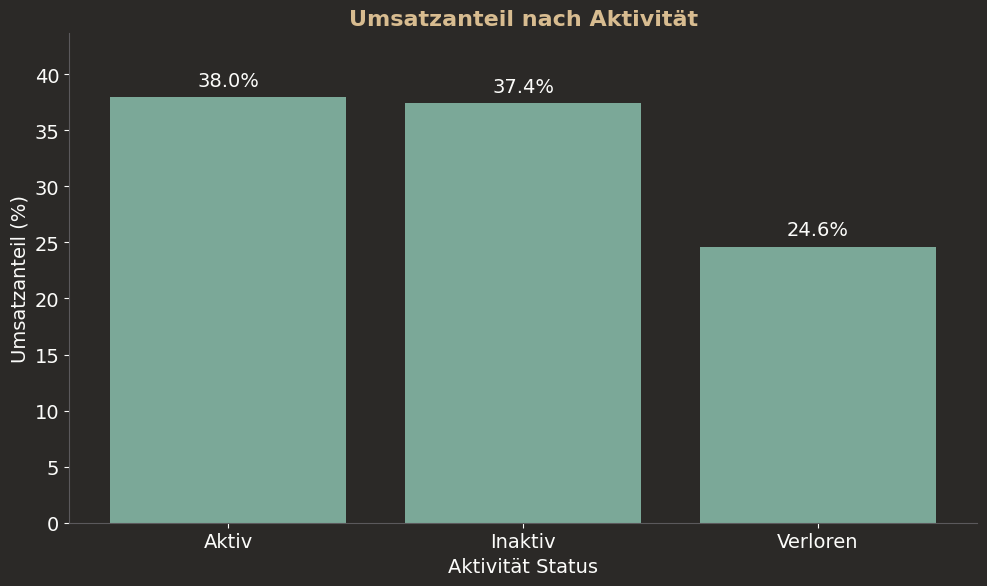

In [39]:
#| echo: true
#| output: true

# 2) Collect small result to Pandas for plotting
pdf = report_aktivitaet.select(
    "aktivitaet_segment", "segment_aktivität_prozent"
).toPandas()


fig, ax = plt.subplots(figsize=(10, 6))

# Barplot with automatically assigned colors
ax.bar(
    pdf["aktivitaet_segment"],
    pdf["segment_aktivität_prozent"]
)

# Labels & formatting
ax.set_title("Umsatzanteil nach Aktivität", fontsize=16)
ax.set_xlabel("Aktivität Status", fontsize=14)
ax.set_ylabel("Umsatzanteil (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=14)

ax.set_ylim(0, pdf["segment_aktivität_prozent"].max() * 1.15)

# Rotate x-labels for readability
plt.xticks(rotation=0, fontsize=14)
ax.grid(False)

# Add % labels above bars
for i, v in enumerate(pdf["segment_aktivität_prozent"]):
    ax.text(i, v + 1, f"{v:.1f}%", ha="center", fontsize=14)

plt.tight_layout()
plt.show()

## Report 2: Interpretation

- The revenue contribution of active and inactive customers is nearly identical, despite differences in engagement behavior.
- This indicates that inactive customers remain a high-value segment, making them a strategic priority for retention efforts.
- Lost customers are a critical isse as they contributed to 24% of total revenue, making them valuable for retention strategies.

## REPORT 3: Verlorene VIPs (Kritisch!)

In [27]:
#| echo: true
#| output: true

verlorene_vips = kunden_segmentiert.filter(
    (col("umsatz_segment") == "VIP") &
    (col("aktivitaet_segment") == "Verloren")
)

print(f"\nAnzahl verlorener VIPs: {verlorene_vips.count():,}")

stats = verlorene_vips.agg(
    spark_round(sum("gesamt_umsatz"), 2).alias("verlorener_umsatz"),
    spark_round(avg("gesamt_umsatz"), 2).alias("avg_umsatz")
).collect()[0]

print(f"Deren bisheriger Umsatz: {stats['verlorener_umsatz']:,.2f} EUR")
print(f"Durchschnitt pro Kunde: {stats['avg_umsatz']:,.2f} EUR")

top10 = (verlorene_vips.select(
    "customer_id",
    "gesamt_umsatz",
    "anzahl_bestellungen",
    "letzte_bestellung",
    "tage_inaktiv"
).orderBy(desc("gesamt_umsatz")).limit(10))

# Convert to table
table_df = (
    top10.toPandas()
        .style.hide(axis="index")
        .format({
            "gesamt_umsatz": "{:,.2f}",
        })
        .set_properties(
            subset=["customer_id", "gesamt_umsatz", "anzahl_bestellungen", "letzte_bestellung", "tage_inaktiv"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

print("\nTop 10 verlorene VIPs:")
table_df


Anzahl verlorener VIPs: 62,312
Deren bisheriger Umsatz: 470,218,054.34 EUR
Durchschnitt pro Kunde: 7,546.19 EUR

Top 10 verlorene VIPs:


customer_id,gesamt_umsatz,anzahl_bestellungen,letzte_bestellung,tage_inaktiv
85733,"25,860.02",17,2024-09-28,93
455882,"25,711.89",17,2024-08-11,141
53226,"25,558.90",20,2024-09-04,117
26705,"24,174.79",18,2024-09-22,99
75067,"24,134.88",15,2024-09-30,91
362128,"23,652.76",21,2024-07-22,161
315539,"23,246.34",17,2024-09-10,111
231746,"23,061.97",19,2024-09-21,100
134045,"22,840.01",16,2024-09-01,120
339963,"22,683.69",15,2024-08-30,122


## REPORT 4: DACH vs International

In [28]:
#| echo: true
#| output: true

report_dach = kunden_segmentiert.groupBy("ist_dach_kunde").agg(
    count("*").alias("anzahl_kunden"),
    spark_round(sum("gesamt_umsatz"), 2).alias("gesamt_umsatz"),
    spark_round(avg("gesamt_umsatz"), 2).alias("avg_umsatz")
)

# Convert to table
table_df = (
    report_dach.toPandas()
        .style.hide(axis="index")
        .format({
            "gesamt_umsatz": "{:,.2f}", "avg_umsatz": "{:,.2f}",
        })
        .set_properties(
            subset=["ist_dach_kunde", "anzahl_kunden", "gesamt_umsatz", "avg_umsatz"],
            **{"text-align": "right"}
        )
        .set_table_styles([
            {"selector": "td",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]},
            {"selector": "th",
             "props": [("padding-right", "8px"), ("padding-left", "8px")]}
        ])
)

table_df

ist_dach_kunde,anzahl_kunden,gesamt_umsatz,avg_umsatz
Nein,278,"511,920.00","1,841.44"
Ja,489697,"2,858,742,634.64","5,837.78"
